Objectifs : 

- regarder le chant initial (fichier wav, deriv spec, score pour chaque feature)

- regarder le chant de Boari (fichier wav, deriv spec, score pour chaque feature)

- Q: Pourquoi le chant initial a une erreur plus faible que celle de Boari ?


# Imports

In [1]:
# Fixed plots
%matplotlib inline
# Dynamic plots
# %matplotlib notebook

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import sys
import math

import birdsonganalysis as bsa
import utils

sys.path.append('../model/')
from synth import synthesize
from measures import bsa_measure
from song_model import SongModel

np.set_printoptions(precision=3)

# Function and variable definitions

In [2]:
# Taken from the GridAnalyser object from birdsonglearningmodel/analysis/utils.py
def boari_synth_song_error(tutor_song, synth_song, p_coefs):
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    msynth = bsa_measure(synth, 44100, coefs=p_coefs)
    mtutor = bsa_measure(tutor, 44100, coefs=p_coefs)
    
    score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)
    
    return score

In [3]:
# g and c are outputs from the bsa_measure function
error_measure = lambda g, c: np.linalg.norm(g - c)

In [5]:
# Generation of the 3 songs: tutor, synthesized, initial song from the model
song_name = "boari_short"

sr, tutor = wavfile.read('../data/{}.wav'.format(song_name))
# for tutor's song NORMALIZATION
tutor = tutor.astype(np.int32)
tutor = 2 * (tutor - tutor.min()) / (tutor.max() - tutor.min()) - 1

# synth is already NORMALIZED
sr, synth = wavfile.read('../data/{}_out.wav'.format(song_name))

prior = [0, 0, 3.141592653589793, 15,
         0, 0, 0.39269908169872414, 45,
         0, 0, 0, 5000,
         0.0,
         0, 0, 0, 0, 0]
rng = np.random.RandomState(0) # seed = 0
sm = SongModel(song=tutor, priors=prior, nb_split=10, rng=rng)
# add fixed_normalize=False in gen_sound() for NORMALIZATION
song = sm.gen_sound(fixed_normalize=False)

print('mean tutor:', np.mean(tutor))
print('mean synth:', np.mean(synth))
print('mean song:', np.mean(song))

mean tutor: -0.09673622387027749
mean synth: -0.032936233227381685
mean song: -1.1315936792487395e-17


# Sound waves and spectral derivatives 

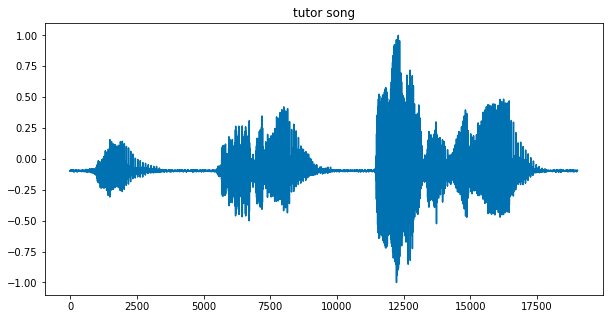

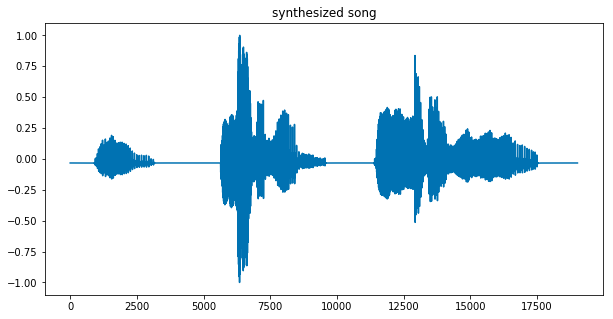

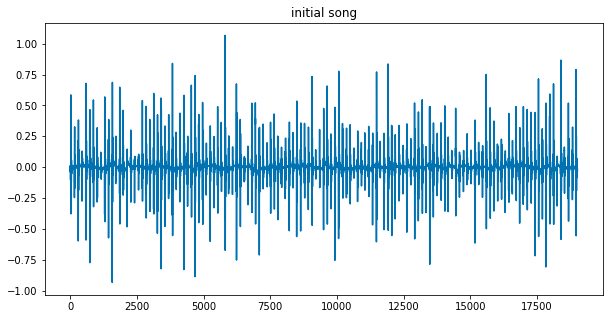

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(tutor)
plt.title("tutor song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(synth)
plt.title("synthesized song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(song)
plt.title("initial song")
plt.show()

# PB n°2
# plt.figure(figsize=(10, 5))
# plt.plot(synth_ab)
# plt.title("synthesized song from alpha beta")
# plt.show()

Rq : après normalisation, on voit bien que le chant du tuteur n'est plus centré en zéro

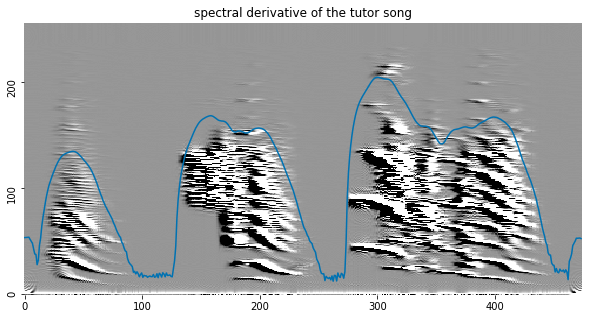

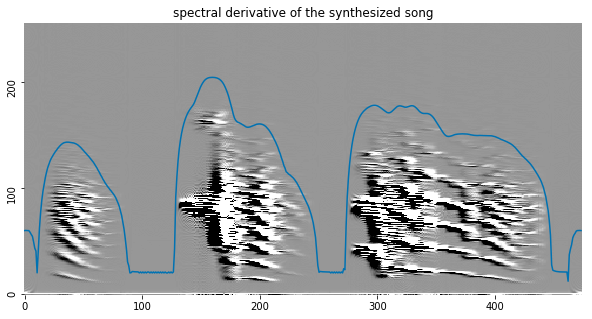

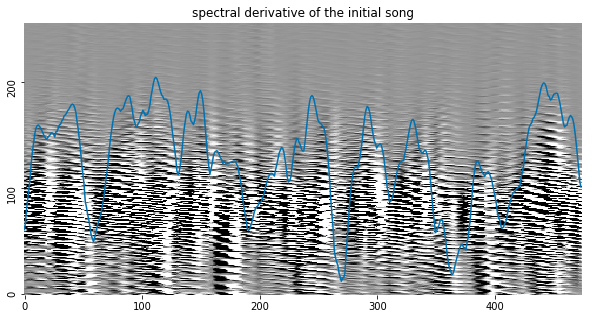

In [7]:
# Spectral derivatives
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
sspec = bsa.spectral_derivs(synth, 256, 40, 1024)
# initial song spectral derivative
ispec = bsa.spectral_derivs(song, 256, 40, 1024)

# PB n°2
# s_abspec = bsa.spectral_derivs(synth_ab, 256, 40, 1024)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(sspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the synthesized song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(ispec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the initial song")
plt.show(fig)

# PB n°2
# fig = plt.figure(figsize=(10, 5))
# ax = fig.gca()
# ax = bsa.spectral_derivs_plot(s_abspec, contrast=0.01, ax=ax)
# bsa.plot_over_spec(bsa.song_amplitude(synth_ab, 256, 40, 1024), ax=ax)
# plt.title("spectral derivative of the synthesized song from alpha beta")
# plt.show(fig)

Rq : apparition d'effets de bord avec le tuteur normalisé + valeur constante en range de fréquence 0 ==> mêmes effets que le chant synth

# bsa_measure function step by step

# Features dict

In [8]:
tutor_feat = bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40)
synth_feat = bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40)
song_feat = bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40)

# Plots of features evolution during the song

In [9]:
fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude']

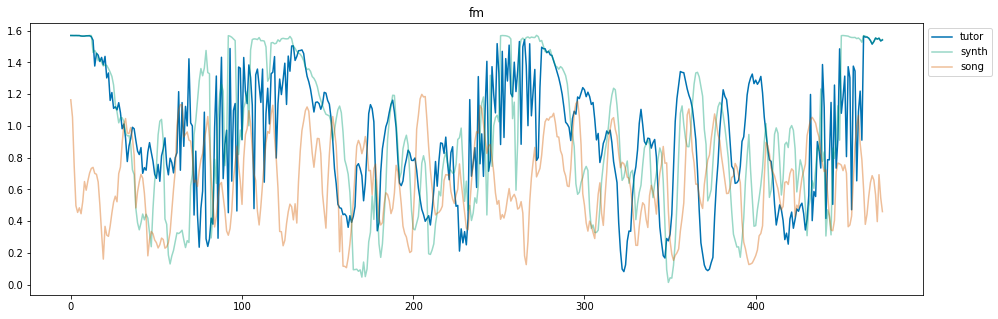

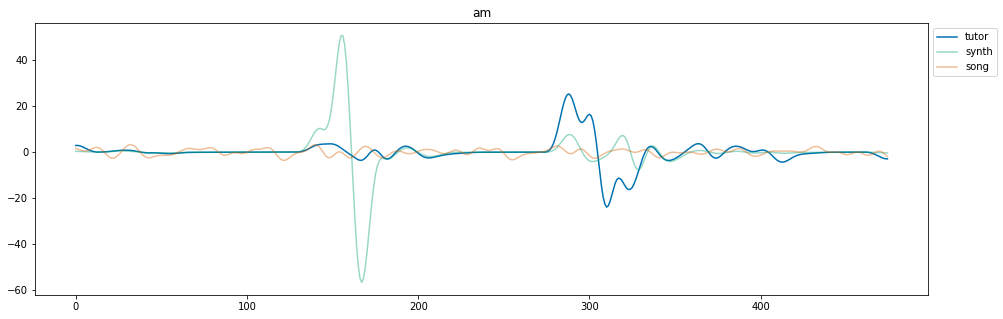

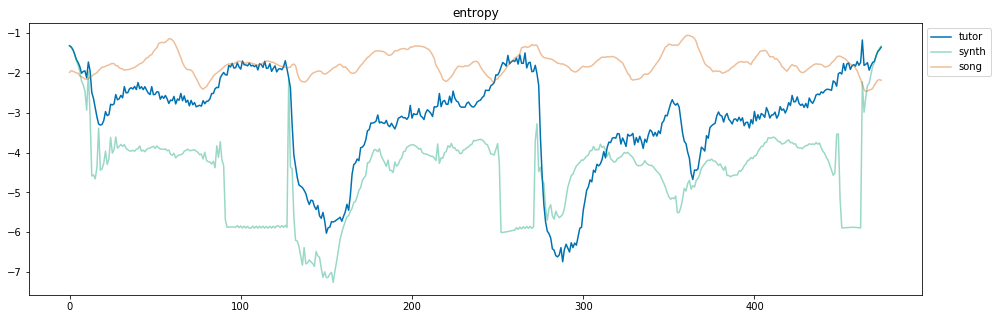

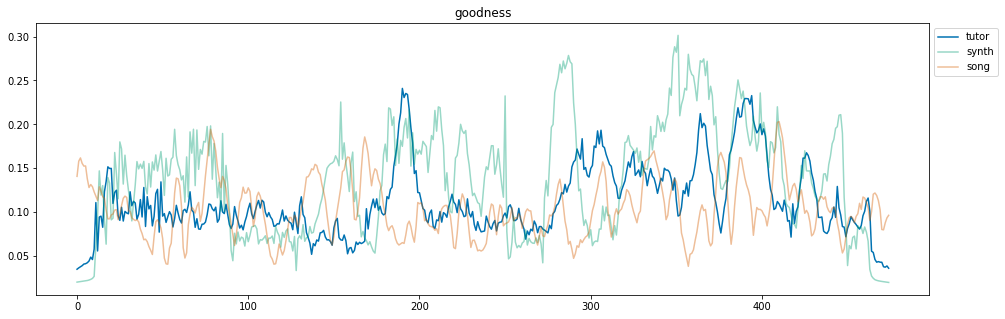

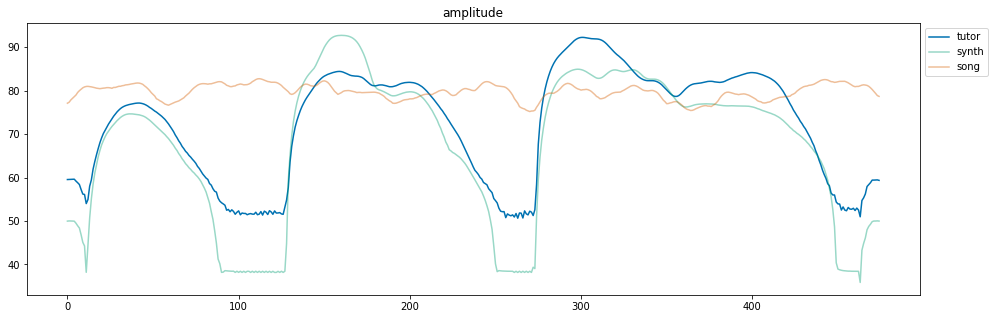

In [10]:
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

Rq :

- chant initial : normalisé ou non, pas de changement dans les features ==> cas particulier, bruit de faible amplitude

- tuteur :
    - effets de bord de même type que synth

    - fm : bruité en début / fin de syllabe et pendant les silences. Dans une syllabe quasi pas de changements

    - am : pas de différence, signaux normalisés ou non

    - entropy : valeurs hautes ont été "écrasée" vers -2

    - goodness : même courbe, mais valeurs plus élevées
    
    - amplitude : valeurs faible plus élevées et plus bruitée ==> Hyp : dû à la moyenne non centrée en zéro.

In [11]:
# min and max value for each features
for feat in fnames:
    print("***  {}  ***".format(feat))
    print("tutor: min = {}, max = {}".format(tutor_feat[feat].min(), tutor_feat[feat].max()))
    print("synth: min = {}, max = {}".format(synth_feat[feat].min(), synth_feat[feat].max()))
    print("song: min = {}, max = {}".format(song_feat[feat].min(), song_feat[feat].max()))
    print()

***  fm  ***
tutor: min = 0.08197100544799206, max = 1.570130123058829
synth: min = 0.01369180269780593, max = 1.5707951026733205
song: min = 0.10654767776780069, max = 1.1988340115474907

***  am  ***
tutor: min = -23.88973094284397, max = 25.29966461592948
synth: min = -56.64229708560819, max = 50.7712574115412
song: min = -3.5589019483925304, max = 3.282735658883562

***  entropy  ***
tutor: min = -6.741934671755298, max = -1.17043775709565
synth: min = -7.262313178213521, max = -1.3199433954849127
song: min = -2.4660080449833335, max = -1.0540998856722084

***  goodness  ***
tutor: min = 0.03467756287746613, max = 0.24097641456801788
synth: min = 0.01958996645753805, max = 0.30148899899839077
song: min = 0.03796634391870316, max = 0.2030755063469316

***  amplitude  ***
tutor: min = 50.634364976531636, max = 92.28620272150269
synth: min = 35.836389104396545, max = 92.75049198726359
song: min = 75.20284972125029, max = 82.76798730357378



# Plots of features evolution during the song

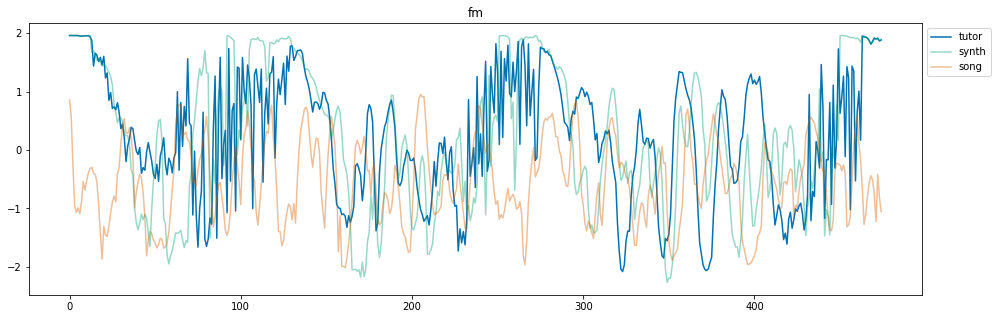

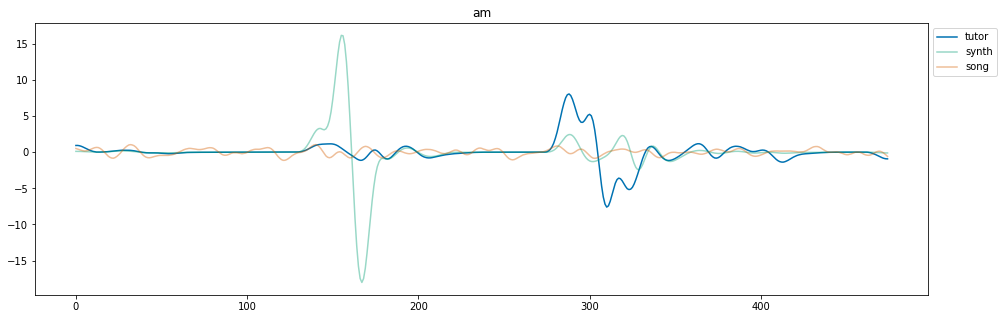

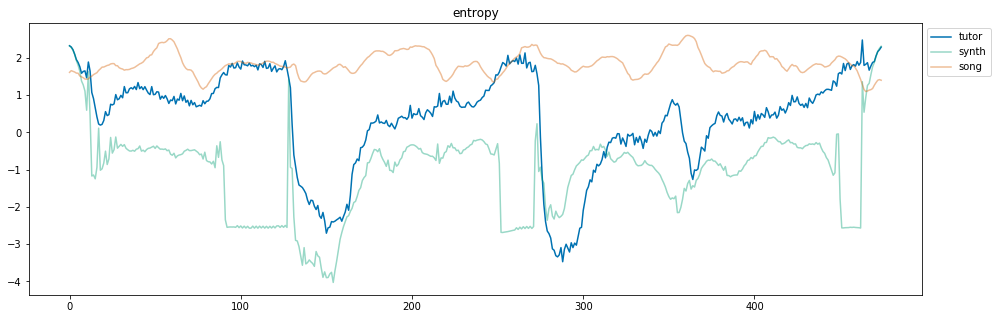

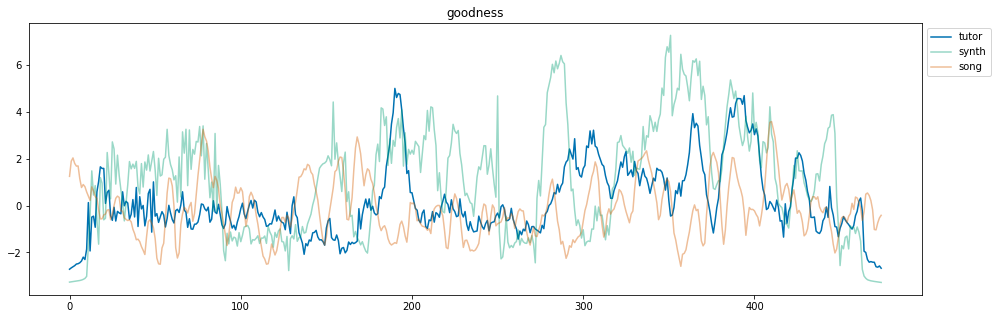

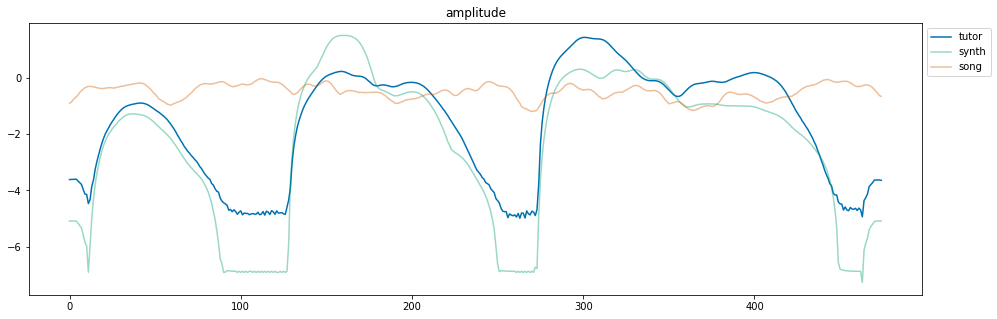

In [12]:
# MAD-NORMALIZED
tutor_feat = bsa.normalize_features(bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40))
synth_feat = bsa.normalize_features(bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40))
song_feat = bsa.normalize_features(bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40))
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

In [13]:
# min and max value for each features
for feat in fnames:
    print("***  {}  ***".format(feat))
    print("tutor: min = {}, max = {}".format(tutor_feat[feat].min(), tutor_feat[feat].max()))
    print("synht: min = {}, max = {}".format(synth_feat[feat].min(), synth_feat[feat].max()))
    print("song: min = {}, max = {}".format(song_feat[feat].min(), song_feat[feat].max()))
    print()

***  fm  ***
tutor: min = -2.0829643315518345, max = 1.9595527241379112
synht: min = -2.268441703158213, max = 1.9613591112382258
song: min = -2.0162029107808968, max = 0.9509436004673198

***  am  ***
tutor: min = -7.599149027988232, max = 8.047378782912006
synht: min = -18.01732821497982, max = 16.14957195965619
song: min = -1.132168133696604, max = 1.0440707055556748

***  entropy  ***
tutor: min = -3.47369855560685, max = 2.482077610633575
synht: min = -4.029968792072915, max = 2.3222602165873787
song: min = 1.0971487915960663, max = 2.6064395787846792

***  goodness  ***
tutor: min = -2.7188680832259964, max = 5.006273296870978
synht: min = -3.2838436731270977, max = 7.272249409529557
song: min = -2.5957151994191197, max = 3.587022185957593

***  amplitude  ***
tutor: min = -4.98866779950953, max = 1.439499759109369
synht: min = -7.272453427815187, max = 1.5111539611220888
song: min = -1.1969902853645051, max = -0.029455438980640118



# Contribution of each feature (in a vector) in the error calculation

In [14]:
# mtutor and msong are results from bsa_measure()
def err_per_feat(mtutor, msong):
    err_feats = np.zeros(mtutor.shape[1])
    for i in range(mtutor.shape[1]):
        err_feats[i] = np.sum(np.absolute(mtutor[:,i] - msong[:,i])**2)
    return err_feats

def carac_to_calculate_err_of_synth(tutor_song, synth_song, p_coefs):
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    return amp, threshold

# calcul a faire apres l'appel de carac_to_calculate_err_of_synth
# err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
# score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)

In [15]:
# TESTS of the functions
coefs = {"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1}

mtutor = bsa_measure(tutor, sr, coefs)
msynth = bsa_measure(synth, sr, coefs)
msong = bsa_measure(song, sr, coefs)

# Own calculation
print("err for INIT song from err per feat:", math.sqrt(np.sum(err_per_feat(mtutor, msong))))
print("sum of err per feat == err squared:", np.sum(err_per_feat(mtutor, msong)))

amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
synth_score = math.sqrt(np.sum(err_per_feat_synth)) / np.sum(amp > threshold) * len(amp)

print("err for SYNTH song from err per feat:", synth_score)
print()

# Check with initial functions
song_err = error_measure(mtutor, msong)
print("Initial song error:", song_err)
print("Initial song error SQUARED:", song_err**2)

synth_err = boari_synth_song_error(tutor, synth, coefs)
print("Boari synth error:", synth_err)

err for INIT song from err per feat: 135.57546263148322
sum of err per feat == err squared: 18380.706067740706
err for SYNTH song from err per feat: 132.1021379943831

Initial song error: 135.57546263148322
Initial song error SQUARED: 18380.706067740703
Boari synth error: 132.1021379943831


In [16]:
coefs_list = [{"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1},
              {"fm": 1, "am": 1, "entropy": 5, "goodness": 1, "amplitude": 5, "pitch": 1}]

# coefs_list = [{"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1}]

In [17]:
fnames = ["fm", "am", "entropy", "goodness", "amplitude"]

for coefs in coefs_list:
    print("fm: {} / am: {} / entropy: {} / goodness: {} / amplitude: {}"
          .format(coefs["fm"], coefs["am"], coefs["entropy"], coefs["goodness"], coefs["amplitude"]))
    
    mtutor = bsa_measure(tutor, sr, coefs)
    msynth = bsa_measure(synth, sr, coefs)
    msong = bsa_measure(song, sr, coefs)
    
    err_feat_vect = err_per_feat(mtutor, msong)
    amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
    err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
    
    synth_err = boari_synth_song_error(tutor, synth, coefs)
    song_err = error_measure(mtutor, msong)
    
    print("Boari err per feat:")
    str_synth = "synth: "
    str_song = "song: "
    for i in range(len(fnames)):
        str_synth += "\t{}: {}".format(fnames[i], round(err_per_feat_synth[i],3))
        str_song += "\t{}: {}".format(fnames[i], round(err_feat_vect[i],3))
    print(str_synth)
    print(str_song)
    print()
    print("Boari synth error:", synth_err)
    print("Initial song error:", song_err)
    print()
    print("Delta:", song_err - synth_err)
    print()

fm: 1 / am: 1 / entropy: 1 / goodness: 1 / amplitude: 1
Boari err per feat:
synth: 	fm: 499.993	am: 4888.586	entropy: 672.436	goodness: 2400.291	amplitude: 312.264
song: 	fm: 1063.439	am: 1536.901	entropy: 1835.904	goodness: 1969.382	amplitude: 2677.047

Boari synth error: 132.1021379943831
Initial song error: 135.57546263148322

Delta: 3.47332463710012

fm: 1 / am: 1 / entropy: 5 / goodness: 1 / amplitude: 5
Boari err per feat:
synth: 	fm: 499.993	am: 4888.586	entropy: 16810.907	goodness: 2400.291	amplitude: 7806.597
song: 	fm: 1063.439	am: 1536.901	entropy: 45897.61	goodness: 1969.382	amplitude: 66926.182

Boari synth error: 224.23781871105223
Initial song error: 355.9375605542827

Delta: 131.69974184323047



Impact de la normalisation : 

- sur le chant appris, voir l'impact d'une normalisation fixe ou non (cf cahier 31/05), à priori il vaut mieux garder une normalisation fixe sur le chant appris, car un changement dans le chant avec l'apparition d'une grande amplitude et le reste qui reste de faible amplitude après normalisation va bcp changer le signal et donc les features ==> a vérifier

- après normalisation, l'ancienne valeur zéro n'est plus forcement à zéro. Q: impact au niveau du son ? Q: impact au niveau des features ?

